In [1]:
import numpy as np
import numpy.matlib as nplib
import cPickle
import os
import gzip
import time
import matplotlib.pyplot as plt

print('... finished import')

debugFPROP = 0
debugBPROP = 0
debugPREDICT = 0
debugBACKPROPAGATE = 0
debugLOSS = 0

if debugFPROP | debugBPROP | debugPREDICT | debugBACKPROPAGATE | debugLOSS:
    print('... debug output ON')

... finished import


# First exercise: Classifying MNIST with MLPs
In this exercise you will implement a Neural Network (or MLP) and classify the MNIST digits with it.
MNIST is a "well hung" dataset that has been used a lot over the years to benchmark different classification algorithms. 
To learn more about it have a look here: http://yann.lecun.com/exdb/mnist/ .

# Data Loading
We first define a function for downloading and loading MNIST.
**WARNING**: Executing it will obviously use up some space on your machine ;). 

In [2]:
def mnist(datasets_dir='./data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    # Load the dataset
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = cPickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = cPickle.load(f)
    f.close()

    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 1, 28, 28)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 1, 28, 28)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 1, 28, 28)
    train_y = train_y.astype('int32')
    rval = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
    print('... done loading data')
    return rval

# Neural Network Layers
We now define "bare bone" neural network layers.
The parts marked with **TODO** are where you should finish the implementation!
Conceptually we will implement the layers as follows:

Each layer has a constructor that takes an input layer plus some additional arguments such as layer size and the activation function name. The layer then uses the provided input layer to compute the layer dimensions, weight shapes, etc. and setup all auxilliary variables.

Each layer then has to provide three functions (as defined in the Layer class below): *output_shape()*, *fprop()* and *brop()*. The output_shape function is used to figure out the shape for the next layer and the *fprop()/bprop()* functions are used to compute forward and backward passes through the network.

In [3]:
# start by defining simple helpers
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def sigmoid_d(x):
    # DONE
    # define the derivative
    return np.exp(x)/((np.exp(x)+1)**2)  #sigmoid(x) * (1 - sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    # DONE
    # derivative
    return 1.0/(np.cosh(x)**2)

def relu(x):
    return np.maximum(0.0, x)

def relu_d(x):
    # DONE 
    # derivative
    if x > 0:
        return 1
    return 0

def softmax(x, axis=1):
    # to make the softmax a "safe" operation we will 
    # first subtract the maximum along the specified axis
    # so that np.exp(x) does not blow up!
    # Note that this does not change the output.
    x_max = np.max(x, axis=axis, keepdims=True)
    x_safe = x - x_max
    e_x = np.exp(x_safe)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def one_hot(labels):
    """this creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
     it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    classes = np.unique(labels)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes,))
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    return one_hot_labels

def unhot(one_hot_labels):
    """ Invert a one hot encoding, creating a flat vector """
    return np.argmax(one_hot_labels, axis=-1)

# then define an activation function class
class Activation(object):
    
    def __init__(self, tname):
        if tname == 'sigmoid':
            self.act = sigmoid
            self.act_d = sigmoid_d
        elif tname == 'tanh':
            self.act = tanh
            self.act_d = tanh_d
        elif tname == 'relu':
            self.act = relu
            self.act_d = relu_d
        else:
            raise ValueError('Invalid activation function.')
            
    def fprop(self, input):
        # we need to remember the last input
        # so that we can calculate the derivative with respect
        # to it later on
        self.last_input = input
        return self.act(input)
    
    def bprop(self, output_grad):
        return output_grad * self.act_d(self.last_input)

# define a base class for layers
class Layer(object):
    
    def fprop(self, input):
        """ Calculate layer output for given input 
            (forward propagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def bprop(self, output_grad):
        """ Calculate input gradient and gradient 
            with respect to weights and bias (backpropagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def output_size(self):
        """ Calculate size of this layer's output.
        input_shape[0] is the number of samples in the input.
        input_shape[1:] is the shape of the feature.
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a base class for loss outputs
# an output layer can then simply be derived
# from both Layer and Loss 
class Loss(object):

    def loss(self, output, output_net):
        """ Calculate mean loss given real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def input_grad(self, output, output_net):
        """ Calculate input gradient real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a base class for parameterized things        
class Parameterized(object):
    
    def params(self):
        """ Return parameters (by reference) """
        raise NotImplementedError('This is an interface class, please use a derived instance')
    
    def grad_params(self):
        """ Return accumulated gradient with respect to params. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a container for providing input to the network
class InputLayer(Layer):
    
    def __init__(self, input_shape):
        if not isinstance(input_shape, tuple):
            raise ValueError("InputLayer requires input_shape as a tuple")
        self.input_shape = input_shape

    def output_size(self):
        return self.input_shape
    
    def fprop(self, input):
        return input
    
    def bprop(self, output_grad):
        return output_grad
        
class FullyConnectedLayer(Layer, Parameterized):
    """ A standard fully connected hidden layer, as discussed in the lecture.
    """
    # NOTE: this means each node is connected to every other node of all adjacent layers, 
    # but not to any other node within the same layer
    
    def __init__(self, input_layer, num_units, 
                 init_stddev, activation_fun=Activation('relu')):
        self.num_units = num_units
        self.activation_fun = activation_fun
        # the input shape will be of size (batch_size, num_units_prev) 
        # where num_units_prev is the number of units in the input 
        # (previous) layer
        self.input_shape = input_layer.output_size()
        

        # DONE: weight initialization: initialize weights with gaussian, bias to 0 
        # this is the weight matrix it should have shape: (num_units_prev, num_units)
        self.W = np.random.normal(0, 0.5,(self.input_shape[1], num_units))
        # and this is the bias vector of shape: (num_units)
        self.b = np.zeros((1,num_units))
    
    
        # create dummy variables for parameter gradients
        # no need to change these here!
        self.dW = None
        self.db = None
    
    def output_size(self):
        return (self.input_shape[0], self.num_units)
    
    def fprop(self, input):
        # DONE: implement forward propagation
        # NOTE: you should also handle the case were 
        #       activation_fun is None (meaning no activation)
        #       then this is simply a linear layer
        
        # you again want to cache the last_input for the bprop implementation below!
        self.last_input = input
        
        
        # IMPLEMENTATION
        # create multiple columns of bias for batch processing
        bias = np.dot(np.ones((input.shape[0], 1)), self.b)
        
        # activation: a = W.z_prev + b  //  z_prev = h(a_prev)     
        a = np.add(np.dot(input, self.W), bias)
        
        # apply activation function
        if self.activation_fun != None:
            h = np.vectorize(self.activation_fun.act)
            z = h(a)
        else:
            # linear activation if activation_fun == none
            z = a                     
        
        # print debug information
        if debugFPROP:  # dimensionality analysis
            print '\t> enter :: fullyConnected: fprop...'
            print '\t\tinput shape', input.shape
            print '\t\tW.T shape', self.W.shape
            print '\t\tdot product shape', np.dot(input, self.W).shape
            print '\t\tb shape', self.b.shape
            print '\t\tactivation shape', a.shape
            print '\t\toutput shape', z.shape
            print '\t< exit :: fullyConnected: fprop...'
        
        return z
        
    def bprop(self, output_grad):
        """ Calculate input gradient (backpropagation). """
        # DONE: implement backward propagation
        
        # DONE: you may have to divide the weights by n
        #       to make gradient checking work 
        #       (since you want to divide the loss by number of inputs)
        # = output_grad.shape[0]
        #self.W /= n
        
        # accumulate gradient wrt. the parameters first
        # we will need to store these to later update
        # the network after a few forward backward passes
        # the gradient wrt. W should be stored as self.dW
        # the gradient wrt. b should be stored as self.db
        
        if debugBPROP:
            print('\t> enter :: fullyConnected: bprop...')
        
        ### IMPLENTATION
        # first compute activation 'a' using the last input (for use in dz/da)
        # a = W.z_prev + b
        a = np.add(np.dot(self.last_input, self.W), np.dot(np.ones((self.last_input.shape[0], 1)), self.b))
        
        if debugBPROP:
            print '\t\tactivation shape', a.shape
        
        # compute dL/da = dL/dz * dz/da  //  output_grad ~> dL/dz
        # apply derivative of activation
        if self.activation_fun != None:
            # first compute derivative of activation function wrt. the last input
            h_d = np.vectorize(self.activation_fun.act_d)
            dzda = h_d(a) #self.activation_fun.act_d(a)  # dz/da
            dLda = np.multiply(output_grad, dzda)  # dL/dz * dz/da
        else:
            dLda = output_grad  # dL/dz * 1

        if debugBPROP:
            print '\t\tdLda shape', dLda.shape
            print '\t\tlast input shape', self.last_input.shape
        
        # compute derivative wrt. the weights
        # dL/dW = dL/da * da/dW = dL/da * h(a) (= dL/da * z)
        sum_dW = []
        for i in range(0, dLda.shape[0]):  #...self.last_input.shape[0]):
            # compute the weight gradient of one stage: #last_input * #dLda
            W_grad = np.outer(self.last_input[i,:], dLda[i,:])
            if debugBPROP:
                print '\t\t\tdW batch', i
                print '\t\t\tdW shape', W_grad.shape
            sum_dW.append(W_grad)
        if debugBPROP:
            print'\t\tsum_dW shape', len(sum_dW)
        
        # then take the mean weight_grad over all batches
        self.dW = np.mean(sum_dW, axis=0)
        
        # compute derivative wrt. the bias
        # dL/db = dL/da * da/db = dL/da * 1
        self.db = np.mean(dLda * 1, axis=0)  # batches are rows (axis 0)
        # HERE WAS THE MAIN FAULT!! enfore db to be of dimension array([[#batches, #nodes]])
        self.db = np.multiply(self.db, np.ones((1, self.db.shape[0])))
        
        if debugBPROP:
            print '\t\tcombining batch information...'
            print '\t\tdW mean shape', self.dW.shape
            print '\t\tdb mean shape', self.db.shape
            print '\t\t< exit :: fullyConnected: bprop...'
        
        return dLda  # input_grad
        
    def params(self):
        return self.W, self.b

    def grad_params(self):
        return self.dW, self.db

# finally we specify the interface for output layers 
# which are layers that also have a loss function
# we will implement two output layers:
#  a Linear, and Softmax (Logistic Regression) layer
# The difference between output layers and and normal 
# layers is that they will be called to compute the gradient
# of the loss through input_grad(). bprop will never 
# be called on them!
class LinearOutput(Layer, Loss):
    """ A simple linear output layer that  
        uses a squared loss (e.g. should be used for regression)
    """
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
        
    def fprop(self, input):
        return input

    def bprop(self, output_grad):
        raise NotImplementedError(
            'LinearOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):
        # DONE: implement gradient of squared loss
        # squared error loss gradient (trivial implementation)
        sqr_loss_grad = -(Y - Y_pred) #/ Y_pred.shape[0]
        return sqr_loss_grad

    def loss(self, Y, Y_pred):
        loss = 0.5 * np.square(Y - Y_pred)
        if debugLOSS:
            print '\tcalculating [linear] loss...', loss.shape
        return np.mean(np.sum(loss))  # axis=1?

class SoftmaxOutput(Layer, Loss):
    """ A softmax output layer that calculates 
        the negative log likelihood as loss
        and should be used for classification.
    """
    
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
    
    def fprop(self, input):
        return softmax(input)
    
    def bprop(self, output_grad):
        raise NotImplementedError(
            'SoftmaxOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):
        # DONE: implement gradient of the negative log likelihood loss
        # HINT: since this would involve taking the log 
        #       of the softmax (which is np.exp(x)/np.sum(x, axis=1))
        #       this gradient computation can be simplified a lot! 
        
        # softmax: exp(x) / sum{exp(x)}      
        # negative log likelihood: L = sum (j upto M) { -log(f_{j,theta}(x)) * y_j} 
        return (Y_pred - Y)

    def loss(self, Y, Y_pred):
        # Assume one-hot encoding of Y
        # calculate softmax first <-- is already calculated
        # to make the loss numerically stable 
        # you may want to add an epsilon in the log ;)
        eps = 1e-10
        # calculate negative log likelihood
        loss = np.multiply(Y, np.log(Y_pred+eps))
        if debugLOSS:
            print '\tcalculating [softmax] loss...', loss.shape
        return -np.sum(loss, axis=1)
        

# Neural Network class
With all layers in place (and properly implemented by you) we can finally define a neural network.
For our purposes a neural network is simply a collection of layers which we will cycle through and on which we will call fprop and bprop to compute partial derivatives with respect to the input and the parameters.

Pay special attention to the *check_gradients()* function in which you should implement automatic differentiation. This function will become your best friend when checking the correctness of your implementation.

In [4]:

class NeuralNetwork:
    """ Our Neural Network container class.
    """
    def __init__(self, layers):
        self.layers = layers
        
    def _loss(self, X, Y):
        Y_pred = self.predict(X)
        return self.layers[-1].loss(Y, Y_pred)

    def predict(self, X):
        """ Calculate an output Y for the given input X. """
        # DONE: implement forward pass through all layers
        if debugPREDICT:
            print('> enter :: propagate')
        # propagate input through all network layers
        for singleLayer in self.layers:
            # calculate layer output with last layer's input by forward propagation
            X = singleLayer.fprop(X)  # X(left) is X_new

        Y_pred = X        
        if debugPREDICT:
            print('< exit :: propagate')
        return Y_pred
    
    def backpropagate(self, Y, Y_pred, upto=0):
        """ Backpropagation of partial derivatives through 
            the complete network up to layer 'upto'
        """
        #prev_grad = self.layers[-1].input_grad(Y, Y_pred)
        # DONE: implement backward pass through all layers
        
        if debugBACKPROPAGATE:
            print('> enter :: backpropagate...')
            
        for i, singleLayer in reversed(list(enumerate(self.layers))):
            if debugBACKPROPAGATE:
                print '\t>> backprop layer:', i
            
            # check abortion criterion
            if i < upto:
                if debugBACKPROPAGATE:
                    print('\treached last layer :: exiting loop')
                break  # exit the for loop    
            # start at the output node (= the loss layer)
            if isinstance(singleLayer, Loss):
                if debugBACKPROPAGATE:
                    print '\tbackpropagate loss layer:'
                prev_grad = singleLayer.input_grad(Y, Y_pred)  # .T ?
                if debugBACKPROPAGATE:
                    print '\tinput grad shape', prev_grad.shape
            # go further through the network from right to left
            elif isinstance(singleLayer, Parameterized):
                if debugBACKPROPAGATE:
                    print '\tbackpropagate parameterized layer:'
                last_calculated_input = singleLayer.bprop(prev_grad)
                if debugBACKPROPAGATE:
                    print '\t\tcalculated last input shape', last_calculated_input.shape
                    print '\t\tW shape', singleLayer.W.shape
                prev_grad = np.dot(last_calculated_input, singleLayer.W.T)  # .T ?
                if debugBACKPROPAGATE:
                    print '\tinput grad shape', prev_grad.shape
            else:
                prev_grad = singleLayer.bprop(prev_grad)
        
        if debugBACKPROPAGATE:
            print('< exit :: backpropagate...')
        return prev_grad
    
    def classification_error(self, X, Y):
        """ Calculate error on the given data 
            assuming they are classes that should be predicted. 
        """
        Y_pred = unhot(self.predict(X))
        error = Y_pred != Y
        return np.mean(error)
    
    def sgd_epoch(self, X, Y, learning_rate, batch_size):
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        for b in range(n_batches):
            # DONE: Implement stochastic gradient descent here
            # start by extracting a batch from X and Y
            # (you can assume the inputs are already shuffled)
            
            
            # IMPLEMENTATION START
            # here no epsilon abortion criterion (go for #n_max iterations)
            # stochastic: compute gradient only on data batch < dataset
            
            # create data batches
            X_batch = X[b*batch_size:(b+1)*batch_size]
            Y_batch = Y[b*batch_size:(b+1)*batch_size]
            #assert(len(X_batch)==batch_size)            

            # DONE: then forward and backward propagation + updates
            # HINT: layer.params() returns parameters *by reference*
            #       so you can easily update in-place
            
            # compute network output given a data batch
            Y_pred = self.predict(X_batch)
            prev_grad = self.backpropagate(Y_batch, Y_pred)
            
            # apply one step of SGD to all layers
            # W_new = W - learning_rate*dW
            # b_new = b - learning_rate*db
            for singleLayer in self.layers:
                if isinstance(singleLayer, Parameterized):
                    # .params()      returns [self.W,  self.b ]
                    # .grad_params() returns [self.dW, self.db]
                    singleLayer.W = singleLayer.params()[0] - learning_rate*(singleLayer.grad_params()[0])
                    singleLayer.b = singleLayer.params()[1] - learning_rate*(singleLayer.grad_params()[1])    
            pass
    
    def gd_epoch(self, X, Y):
        # DONE: Implement batch gradient descent here
        # A few hints:
        #   There are two strategies you can follow:
        #   Either shove the whole dataset throught the network
        #   at once (which can be problematic for large datasets)
        #   or run through it batch wise as in the sgd approach
        #   and accumulate the gradients for all parameters as
        #   you go through the data. Either way you should then
        #   do one gradient step after you went through the
        #   complete dataset!
        
        # compute network output for the whole dataset once
        Y_pred = self.predict(X)
        prev_grad = self.backpropagate(Y, Y_pred)
        # for implementation details, see SGD
        for singleLayer in self.Layers:
                if isinstance(singleLayer, Parameterized):
                    # .params()      returns [self.W,  self.b ]
                    # .grad_params() returns [self.dW, self.db]
                    singkleLayer.W = singleLayer.params()[0] - learning_rate*(singleLayer.grad_params()[0])
                    singleLayer.b = singleLayer.params()[1] - learning_rate*(singleLayer.grad_params()[1])    
        pass
    
    def train(self, X, Y, learning_rate=0.1, max_epochs=100, 
              batch_size=64, descent_type="sgd", y_one_hot=True):
        """ Train network on the given data. """
        
        # store the error values for each training epoch
        error_training = []
        error_validation = []
        
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        
        if y_one_hot:
            Y_train = one_hot(Y)
        else:
            Y_train = Y
        print("... starting training")
        
        for e in range(max_epochs+1):
            if descent_type == "sgd":
                self.sgd_epoch(X, Y_train, learning_rate, batch_size)
            elif descent_type == "gd":
                self.gd_epoch(X, Y_train, learning_rate)
            else:
                raise NotImplementedError("Unknown gradient descent type {}".format(descent_type))

            # Output error on the training data
            train_loss = self._loss(X, Y_train)
            train_error = self.classification_error(X, Y)
            
            # print training epoch information
            print('epoch {:.0f}\t|\ttrain error {:.2%}'.format(int(e), float(train_error)))
            
            # DONE: Output error on the validation data
            validation_error = self.classification_error(X_validation, Y_validation)
            
            # store the errors per training epoch
            error_training.append(train_error)
            error_validation.append(validation_error)
            
        return (error_training, error_validation)
    
    
    def check_gradients(self, X, Y):
        """ Helper function to test the parameter gradients for
        correctness. """
        for l, layer in enumerate(self.layers):
            if isinstance(layer, Parameterized):
                print('checking gradient for layer {}'.format(l))
                for p, param in enumerate(layer.params()):
                    # we iterate through all parameters
                    param_shape = param.shape
                    # define functions for conveniently swapping
                    # out parameters of this specific layer and 
                    # computing loss and gradient with these 
                    # changed parametrs
                    def output_given_params(param_new):
                        """ A function that will compute the output 
                            of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # return computed loss
                        return self._loss(X, Y)

                    def grad_given_params(param_new):
                        """A function that will compute the gradient 
                           of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # Forward propagation through the net
                        Y_pred = self.predict(X)
                        # Backpropagation of partial derivatives
                        self.backpropagate(Y, Y_pred, upto=l)
                        # return the computed gradient 
                        return np.ravel(self.layers[l].grad_params()[p])

                    # let the initial parameters be the ones that
                    # are currently placed in the network and flatten them
                    # to a vector for convenient comparisons, printing etc.
                    param_init = np.ravel(np.copy(param))
                    
                    # TODO ####################################
                    # TODO compute the gradient with respect to
                    #      the initial parameters in two ways:
                    #      1) with grad_given_params()
                    #      2) with finite differences 
                    #         using output_given_params()
                    #         (as discussed in the lecture)
                    #      if your implementation is correct 
                    #      both results should be epsilon close
                    #      to each other!
                    # TODO ####################################
                    epsilon = 1e-4
                    # making sure your gradient checking routine itself 
                    # has no errors can be a bit tricky. To debug it
                    # you can "cheat" by using scipy which implements
                    # gradient checking exactly the way you should!
                    # To do that simply run the following here:
                    import scipy.optimize
                    err = scipy.optimize.check_grad(output_given_params, grad_given_params, param_init)
                    #loss_base = output_given_params(param_init)
                    # TODO this should hold the gradient as calculated through bprop
                    #gparam_bprop = None 
                    # TODO this should hold the gradient calculated through 
                    #      finite differences
                    #gparam_fd = np.zeros_like(param_init)
                    # calculate difference between them
                    #err = np.mean(np.abs(gparam_bprop - gparam_fd))
                    print('diff {:.2e}'.format(err))
                    assert(err < epsilon)
                    
                    # reset the parameters to their initial values
                    param[:] = np.reshape(param_init, param_shape)

# Gradient Checking
After implementing everything it is always a good idea to setup some layers and perform gradient
checking on random data. **Note** that this is only an example! It is not a useful network architecture ;). We also expect you to play around with this to test all your implemented components.

In [5]:
input_shape = (1, 10)
n_labels = 6
layers = [InputLayer(input_shape)]

layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=15,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=4,
                init_stddev=0.1,
                activation_fun=Activation('tanh')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=n_labels,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(SoftmaxOutput(layers[-1]))
nn = NeuralNetwork(layers)

In [6]:
# create random data
X = np.random.normal(size=input_shape)
# and random labels
Y = np.zeros((input_shape[0], n_labels))
for i in range(Y.shape[0]):
    idx = np.random.randint(n_labels)
    Y[i, idx] = 1.

In [7]:
nn.check_gradients(X, Y)

checking gradient for layer 1
diff 1.12e-07
diff 3.07e-08
checking gradient for layer 2
diff 7.47e-08
diff 2.95e-08
checking gradient for layer 3
diff 4.32e-08
diff 9.33e-09


# Training on MNIST
Finally we can let our network run on the MNIST dataset!

First load the data and reshape it.

In [8]:
# load
Dtrain, Dval, Dtest = mnist()
X_train, Y_train = Dtrain


print('... splitting data')
# Downsample training data to make it a bit faster for testing this code
n_train_samples = 50000
train_idxs = np.random.permutation(X_train.shape[0])[:n_train_samples]
X_train = X_train[train_idxs]
Y_train = Y_train[train_idxs]

# create validation data
X_validation, Y_validation = Dval
n_val_samples = 10000
val_idxs = np.random.permutation(X_validation.shape[0])[:n_val_samples]
X_validation = X_validation[val_idxs]
Y_validation = Y_validation[val_idxs]

# create test data
X_test, Y_test = Dtest
n_test_samples = 10000
test_idxs = np.random.permutation(X_test.shape[0])[:n_test_samples]
X_test = X_test[test_idxs]
Y_test = Y_test[test_idxs]

# reshape the data for the calculation of the classification error 
X_validation = X_validation.reshape(X_validation.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print('... done formatting data')

... loading data
... done loading data
... splitting data
... done formatting data


*Dtrain* contains 50k images which are of size 28 x 28 pixels. Hence:

In [9]:
print("X_train shape: {}".format(np.shape(X_train)))
print("y_train shape: {}".format(np.shape(Y_train)))

X_train shape: (50000L, 1L, 28L, 28L)
y_train shape: (50000L,)


y_train will automatically be converted in the *train()* function to one_hot encoding.


But we need to reshape X_train, as our Network expects flat vectors of size 28*28 as input!

In [10]:
X_train = X_train.reshape(X_train.shape[0], -1)
print("Reshaped X_train size: {}".format(X_train.shape))

Reshaped X_train size: (50000L, 784L)


Ah, much better ;-)! 

Now we can finally really start training a Network!


I pre-defined a small Network for you below. Again This is not really a good default and will not produce state of the art results. Please play around with this a bit. See how different activation functions and training procedures (gd / sgd) affect the result.

In [13]:
#import time

# Setup a small MLP / Neural Network
# we can set the first shape to None here to indicate that
# we will input a variable number inputs to the network
input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=49,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=98,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
train_err0, val_err0 = nn.train(X_train, Y_train, learning_rate=0.2, 
         max_epochs=20, batch_size=20, y_one_hot=True)
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))

... starting training
epoch 0	|	train error 16.44%
epoch 1	|	train error 11.16%
epoch 2	|	train error 9.98%
epoch 3	|	train error 8.83%
epoch 4	|	train error 8.63%
epoch 5	|	train error 8.08%
epoch 6	|	train error 7.84%
epoch 7	|	train error 7.20%
epoch 8	|	train error 6.83%
epoch 9	|	train error 6.59%
epoch 10	|	train error 6.40%
epoch 11	|	train error 6.17%
epoch 12	|	train error 6.21%
epoch 13	|	train error 5.55%
epoch 14	|	train error 5.51%
epoch 15	|	train error 5.71%
epoch 16	|	train error 5.06%
epoch 17	|	train error 5.30%
epoch 18	|	train error 4.93%
epoch 19	|	train error 4.52%
epoch 20	|	train error 5.07%
Duration: 605.0s


# Figure out a reasonable Network that achieves good performance
As the last part of this task, setup a network that works well and gets reasonable accuracy, say ~ 1-3 percent error on the **validation set**. 
Train this network on the complete data and compute the **test error**. 

Once you have done this, visualize a few digits from the test set that the network gets right as well as a few that the network gets wrong!

In [15]:
test_error = nn.classification_error(X_test, Y_test)
print ('test error: {:.2%}'.format(test_error))

test error: 6.55%


## Try 2
setup another MLP configuration
- try more nodes in first layer

In [14]:
import time

input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=68,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=98,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn2 = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
train_err2, val_err2 = nn2.train(X_train, Y_train, learning_rate=0.2, 
         max_epochs=20, batch_size=20, y_one_hot=True)
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))

... starting training
epoch 0	|	train error 21.58%
epoch 1	|	train error 15.05%
epoch 2	|	train error 12.90%
epoch 3	|	train error 11.20%
epoch 4	|	train error 9.07%
epoch 5	|	train error 8.56%
epoch 6	|	train error 7.69%
epoch 7	|	train error 7.37%
epoch 8	|	train error 7.35%
epoch 9	|	train error 6.82%
epoch 10	|	train error 6.62%
epoch 11	|	train error 6.44%
epoch 12	|	train error 6.26%
epoch 13	|	train error 6.26%
epoch 14	|	train error 5.97%
epoch 15	|	train error 6.08%
epoch 16	|	train error 5.87%
epoch 17	|	train error 5.72%
epoch 18	|	train error 5.87%
epoch 19	|	train error 5.82%
epoch 20	|	train error 5.72%
Duration: 1364.8s


not that much better...

## Try 3
- try more nodes in second layer

In [18]:
input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=49,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=142,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn3 = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
train_err3, val_err3 = nn3.train(X_train, Y_train, learning_rate=0.2, 
         max_epochs=20, batch_size=20, y_one_hot=True)
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))

... starting training
epoch 0	|	train error 39.56%
epoch 1	|	train error 17.64%
epoch 2	|	train error 11.25%
epoch 3	|	train error 9.63%
epoch 4	|	train error 8.63%
epoch 5	|	train error 7.53%
epoch 6	|	train error 7.48%
epoch 7	|	train error 7.11%
epoch 8	|	train error 6.51%
epoch 9	|	train error 6.38%
epoch 10	|	train error 6.20%
epoch 11	|	train error 6.34%
epoch 12	|	train error 5.83%
epoch 13	|	train error 6.14%
epoch 14	|	train error 5.75%
epoch 15	|	train error 5.78%
epoch 16	|	train error 5.44%
epoch 17	|	train error 5.24%
epoch 18	|	train error 5.11%
epoch 19	|	train error 4.91%
epoch 20	|	train error 5.28%
Duration: 1486.9s


same here, no real progress...

## Try 4
- try additional layer

In [19]:
input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=49,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=98,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=49,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn4 = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
train_err4, val_err4 = nn4.train(X_train, Y_train, learning_rate=0.2, 
         max_epochs=20, batch_size=20, y_one_hot=True)
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))

... starting training
epoch 0	|	train error 88.64%
epoch 1	|	train error 88.64%
epoch 2	|	train error 88.64%
epoch 3	|	train error 88.64%
epoch 4	|	train error 88.64%
epoch 5	|	train error 88.64%


KeyboardInterrupt: 

- aborted!
- what's going on here? No convergence at all...

## Refining ...
- first try was kind of best: play around with the #[nodes per layer] in a smaller vicinity.<br>
- altering #[layer 1 nodes] =  {39, 44}, both not as good as initial configuration {49}

In [16]:
input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=49,  #[49], 39, 44
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=89,  #[98], 89
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn5 = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
train_err_epoch5, val_err_epoch5 = nn5.train(X_train, Y_train, learning_rate=0.2, 
         max_epochs=20, batch_size=20, y_one_hot=True)
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))

... starting training
epoch 0	|	train error 11.13%
epoch 1	|	train error 8.59%
epoch 2	|	train error 7.67%
epoch 3	|	train error 6.87%
epoch 4	|	train error 6.74%
epoch 5	|	train error 6.38%
epoch 6	|	train error 6.27%
epoch 7	|	train error 6.07%
epoch 8	|	train error 5.88%
epoch 9	|	train error 5.47%
epoch 10	|	train error 5.33%
epoch 11	|	train error 5.62%
epoch 12	|	train error 5.27%
epoch 13	|	train error 5.05%
epoch 14	|	train error 4.83%
epoch 15	|	train error 5.02%
epoch 16	|	train error 4.58%
epoch 17	|	train error 4.42%
epoch 18	|	train error 4.68%
epoch 19	|	train error 4.50%
epoch 20	|	train error 4.09%
Duration: 598.0s


In [17]:
print('test error {:.2%}'.format(nn5.classification_error(X_test, Y_test)))

test error 5.70%


- test error slightly better than the initial run. However, multiple executions show some variance here.

## Iterate through a few MLPs with minor changes in hyperparameters

In [12]:
import time

input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=49,  #[49], 39, 44
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=110,  #[98], 89
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn6 = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
train_err_epoch6, val_err_epoch6 = nn6.train(X_train, Y_train, learning_rate=0.2, 
         max_epochs=20, batch_size=20, y_one_hot=True)
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))


input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=49,  #[49], 39, 44
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=89,  #[98], 89
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn7 = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
train_err_epoch7, val_err_epoch7 = nn7.train(X_train, Y_train, learning_rate=0.4, 
         max_epochs=20, batch_size=20, y_one_hot=True)
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))


input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=49,  #[49], 39, 44
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=98,  #[98], 89
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn8 = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
train_err_epoch8, val_err_epoch8 = nn8.train(X_train, Y_train, learning_rate=0.3, 
         max_epochs=20, batch_size=20, y_one_hot=True)
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))


input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=49,  #[49], 39, 44
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=98,  #[98], 89
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn9 = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
train_err_epoch9, val_err_epoch9 = nn9.train(X_train, Y_train, learning_rate=0.2, 
         max_epochs=20, batch_size=10, y_one_hot=True)
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))


input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=49,  #[49], 39, 44
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=98,  #[98], 89
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn10 = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
train_err_epoch10, val_err_epoch10 = nn10.train(X_train, Y_train, learning_rate=0.05, 
         max_epochs=20, batch_size=20, y_one_hot=True)
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))


input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=49,  #[49], 39, 44
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=98,  #[98], 89
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn11 = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
train_err_epoch11, val_err_epoch11 = nn11.train(X_train, Y_train, learning_rate=0.2, 
         max_epochs=20, batch_size=30, y_one_hot=True)
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))

... starting training
epoch 0	|	train error 78.82%
epoch 1	|	train error 78.32%
epoch 2	|	train error 59.66%
epoch 3	|	train error 47.57%
epoch 4	|	train error 44.92%
epoch 5	|	train error 27.82%
epoch 6	|	train error 21.56%
epoch 7	|	train error 24.08%
epoch 8	|	train error 16.13%
epoch 9	|	train error 13.93%
epoch 10	|	train error 14.03%
epoch 11	|	train error 12.14%
epoch 12	|	train error 11.61%
epoch 13	|	train error 10.91%
epoch 14	|	train error 10.78%
epoch 15	|	train error 10.35%
epoch 16	|	train error 9.42%
epoch 17	|	train error 11.23%
epoch 18	|	train error 9.47%
epoch 19	|	train error 9.77%
epoch 20	|	train error 9.48%
Duration: 615.0s
... starting training
epoch 0	|	train error 88.62%
epoch 1	|	train error 82.23%
epoch 2	|	train error 88.64%
epoch 3	|	train error 71.18%
epoch 4	|	train error 80.88%
epoch 5	|	train error 80.65%
epoch 6	|	train error 79.20%
epoch 7	|	train error 79.10%
epoch 8	|	train error 79.10%
epoch 9	|	train error 81.83%
epoch 10	|	train error 80.94%
epo

KeyboardInterrupt: 

## Interpretation
especially the last two MLPs (although the last run was aborted by the user) look promising considering the training error > inspect in more detail
- evaluate the network with learning_rate = 0.05 and batch_size = 20

In [18]:
input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=49,  #[49], 39, 44
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=98,  #[98], 89
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn10 = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
train_err_epoch10, val_err_epoch10 = nn10.train(X_train, Y_train, learning_rate=0.05, 
         max_epochs=20, batch_size=20, y_one_hot=True)
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))

... starting training
epoch 0	|	train error 10.62%
epoch 1	|	train error 7.95%
epoch 2	|	train error 6.84%
epoch 3	|	train error 6.12%
epoch 4	|	train error 5.64%
epoch 5	|	train error 5.12%
epoch 6	|	train error 4.77%
epoch 7	|	train error 4.50%
epoch 8	|	train error 4.30%
epoch 9	|	train error 4.15%
epoch 10	|	train error 3.90%
epoch 11	|	train error 3.83%
epoch 12	|	train error 3.75%
epoch 13	|	train error 3.63%
epoch 14	|	train error 3.47%
epoch 15	|	train error 3.46%
epoch 16	|	train error 3.35%
epoch 17	|	train error 3.21%
epoch 18	|	train error 3.15%
epoch 19	|	train error 2.94%
epoch 20	|	train error 2.90%
Duration: 608.7s


In [40]:
print('test error {:.2%}'.format(nn10.classification_error(X_test, Y_test)))

test error 5.21%


- test error looks better the initial guess.
- inspect validation error:

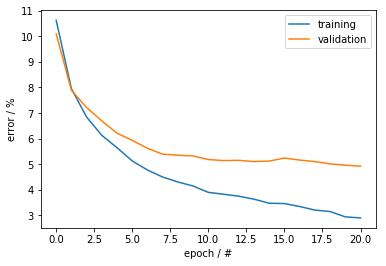

In [37]:
# get inline graphs
%matplotlib inline

epoch = range(20+1)

f = plt.figure()
p = plt.plot(epoch, np.multiply(train_err_epoch10, 100))
p = plt.plot(epoch, np.multiply(val_err_epoch10, 100))
plt.xlabel('epoch / #')
plt.ylabel('error / %')
l = plt.legend(['training', 'validation'])

- the validation error is higher than the training error, maybe slight overfitting of the training data.
- test error is in the range of validation error after 20 iterations
- overall, this configuration [nn10] looks best so far!
<br><br>
- try the last configuration from above. Here, the batch size is increased. learning_rate = 0.2, batch_size = 30

In [ ]:
input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=49,  #[49], 39, 44
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=98,  #[98], 89
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn11 = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
train_err_epoch11, val_err_epoch11 = nn11.train(X_train, Y_train, learning_rate=0.2, 
         max_epochs=20, batch_size=30, y_one_hot=True)
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))

In [41]:
print('test error {:.2%}'.format(nn11.classification_error(X_test, Y_test)))

test error 6.23%


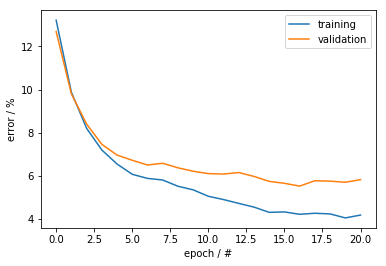

In [44]:
%matplotlib inline

epoch = range(20+1)

f = plt.figure()
p = plt.plot(epoch, np.multiply(train_err_epoch11, 100))
p = plt.plot(epoch, np.multiply(val_err_epoch11, 100))
plt.xlabel('epoch / #')
plt.ylabel('error / %')
l = plt.legend(['training', 'validation'])

- in this run, the difference between training and validation error are smaller than in the previous MLP.
- this is likely due to the larger batch size
- however, the test error of nn10 is lower than for nn11

## Evaluation: nn10 [the best one]
- putting out some numbers for which the network predicts right and wrong

In [57]:
for i in range(0,40):
    prediction = np.argmax(np.mean(softmax(nn10.predict(X_test[i])),axis=0))
    actual = Y_test[i]
    print('Value #' + str(i) + '\tPrediciton: '+str(prediction)+ ' Actual: '+str(actual))

Value #0	Prediciton: 3 Actual: 3
Value #1	Prediciton: 1 Actual: 1
Value #2	Prediciton: 2 Actual: 2
Value #3	Prediciton: 8 Actual: 8
Value #4	Prediciton: 8 Actual: 8
Value #5	Prediciton: 5 Actual: 5
Value #6	Prediciton: 0 Actual: 0
Value #7	Prediciton: 8 Actual: 3
Value #8	Prediciton: 1 Actual: 1
Value #9	Prediciton: 8 Actual: 8
Value #10	Prediciton: 0 Actual: 0
Value #11	Prediciton: 6 Actual: 6
Value #12	Prediciton: 0 Actual: 0
Value #13	Prediciton: 8 Actual: 8
Value #14	Prediciton: 9 Actual: 9
Value #15	Prediciton: 4 Actual: 4
Value #16	Prediciton: 4 Actual: 4
Value #17	Prediciton: 8 Actual: 8
Value #18	Prediciton: 1 Actual: 1
Value #19	Prediciton: 0 Actual: 0
Value #20	Prediciton: 1 Actual: 1
Value #21	Prediciton: 5 Actual: 5
Value #22	Prediciton: 0 Actual: 0
Value #23	Prediciton: 8 Actual: 8
Value #24	Prediciton: 9 Actual: 7
Value #25	Prediciton: 7 Actual: 7
Value #26	Prediciton: 6 Actual: 6
Value #27	Prediciton: 3 Actual: 3
Value #28	Prediciton: 4 Actual: 4
Value #29	Prediciton: 3 

- most predictions are correct
- some are incorrectly classified, look at values {7,24}

In [59]:
print('test error {:.2%}'.format(nn10.classification_error(X_test, Y_test)))

test error 5.21%
